In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Add, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import tensorflow as tf

# --- Load sensor data function ---
def load_sensor_data(base_path, sensor_name):
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_train.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_train.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_train.txt')
body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_train.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_train.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_train.txt')
total_acc_x = load_sensor_data(base_path, 'total_acc_x_train.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_train.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_train.txt')

# Stack into 3D array: (samples, timesteps, features)
X = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z
], axis=2)  # shape: (7352, 128, 9)
print("X shape:", X.shape)

# Load labels
y = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt", delim_whitespace=True, header=None).values.flatten()

# Standardize per feature
nsamples, ntimesteps, nfeatures = X.shape
X_reshaped = X.reshape(-1, nfeatures)  # (7352*128, 9)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(nsamples, ntimesteps, nfeatures)

# Encode labels to 0-based integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Labels:", np.unique(y_encoded))

# --- Jittering function ---
def jitter(X, sigma=0.05):
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + noise

# --- Augment classes 3 and 4 with 500 samples each ---
augmented_X = []
augmented_y = []

for cls in [3, 4]:
    cls_indices = np.where(y_encoded == cls)[0]
    chosen_indices = np.random.choice(cls_indices, 500, replace=True)
    for idx in chosen_indices:
        augmented_sample = jitter(X_scaled[idx:idx+1], sigma=0.05)  # keep shape (1, 128, 9)
        augmented_X.append(augmented_sample)
        augmented_y.append(cls)

# Stack augmented data
X_augmented = np.vstack(augmented_X)
y_augmented = np.array(augmented_y)

# Combine with original training data
X_train_final = np.vstack([X_scaled, X_augmented])
y_train_final = np.hstack([y_encoded, y_augmented])

print("After augmentation:")
print("X_train_final shape:", X_train_final.shape)
print("y_train_final shape:", y_train_final.shape)
print("Unique labels after augmentation:", np.unique(y_train_final))


C:\Users\MSI\AppData\Local\Temp\ipykernel_6332\2108177170.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_6332\2108177170.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_6332\2108177170.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_6332\2108177170.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated

X shape: (7352, 128, 9)


C:\Users\MSI\AppData\Local\Temp\ipykernel_6332\2108177170.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt", delim_whitespace=True, header=None).values.flatten()


Labels: [0 1 2 3 4 5]
After augmentation:
X_train_final shape: (8352, 128, 9)
y_train_final shape: (8352,)
Unique labels after augmentation: [0 1 2 3 4 5]


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, LSTM, GRU, Dense, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout,
    Add, Bidirectional, LSTM, GRU, Dense
)
from tensorflow.keras.regularizers import l2

def build_cnn_bilstm_gru_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First Conv1D Block
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Residual Conv1D Block
    conv1 = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    x = Add()([x, conv1])
    x = Dropout(0.2)(x)
    x = Conv1D(128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # BiLSTM Layer
    x = Bidirectional(LSTM(128, return_sequences=True))(x)

    # GRU Layer
    x = GRU(128, return_sequences=False)(x)
    x = Dropout(0.2)(x)

    # Dense Layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Model Compilation
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [7]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


Epoch 1/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 89s 910ms/step - accuracy: 0.6932 - loss: 3.1391 - val_accuracy: 0.8368 - val_loss: 1.9603 - learning_rate: 0.0010
Epoch 2/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 668ms/step - accuracy: 0.9267 - loss: 1.2026 - val_accuracy: 0.9232 - val_loss: 0.8971 - learning_rate: 0.0010
Epoch 3/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 408ms/step - accuracy: 0.9457 - loss: 0.6743 - val_accuracy: 0.9443 - val_loss: 0.5494 - learning_rate: 0.0010
Epoch 4/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 433ms/step - accuracy: 0.9402 - loss: 0.4978 - val_accuracy: 0.9409 - val_loss: 0.4043 - learning_rate: 0.0010
Epoch 5/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 428ms/step - accuracy: 0.9505 - loss: 0.3762 - val_accuracy: 0.9035 - val_loss: 0.4025 - learning_rate: 0.0010
Epoch 6/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 425ms/step - accuracy: 0.9463 - loss: 0.3116 - val_accuracy: 0.9361 - val_loss: 0.3392 - learning_rate: 0.0010
Epoch 7/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 425ms/step - accuracy: 0.9419 - loss: 0.

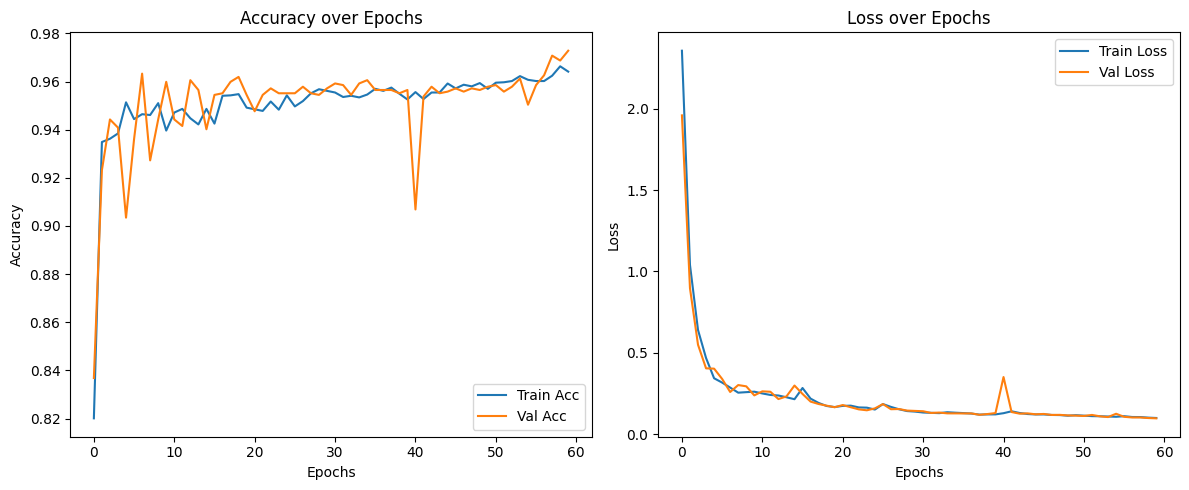

In [8]:
model = build_cnn_bilstm_gru_model(input_shape=(ntimesteps, nfeatures), num_classes=len(np.unique(y_encoded)))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:\n")
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_.astype(str)))

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)




In [9]:
model.save(r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\Models\cnn_lstm(jittering).h5')

C:\Users\MSI\AppData\Local\Temp\ipykernel_6332\829148097.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_6332\829148097.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_6332\829148097.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_6332\829148097.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and

Original X_test shape: (2947, 128, 9)
Reduced X_test shape: (1473, 128, 9)


C:\Users\MSI\AppData\Local\Temp\ipykernel_6332\829148097.py:41: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_test = pd.read_csv(


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
Accuracy: 0.9124236252545825

Classification Report:

              precision    recall  f1-score   support

           1       0.98      0.95      0.96       241
           2       0.99      0.94      0.97       246
           3       0.88      0.97      0.92       197
           4       0.80      0.84      0.82       256
           5       0.84      0.78      0.81       254
           6       0.99      1.00      1.00       279

    accuracy                           0.91      1473
   macro avg       0.91      0.91      0.91      1473
weighted avg       0.91      0.91      0.91      1473



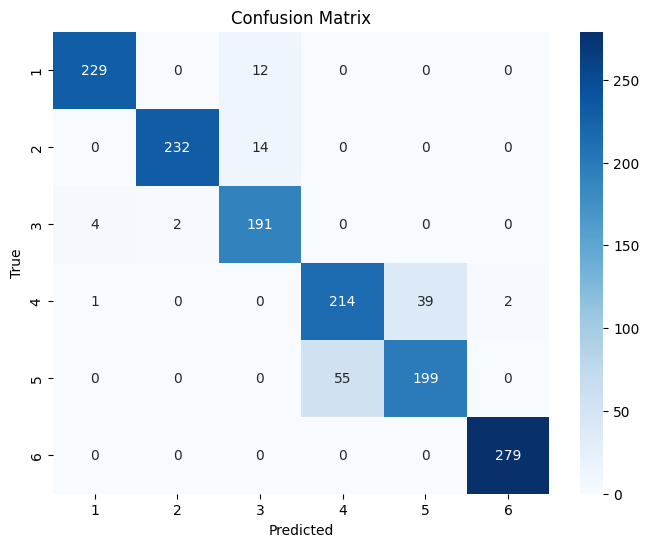

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns


# --- Load test sensor signal data from UCI HAR Dataset ---
def load_sensor_data(base_path, sensor_name):
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

# Use the TEST path
base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_test.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_test.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_test.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_test.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_test.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_test.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_test.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_test.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_test.txt')

# Stack all 9 axes into shape: (samples, timesteps, features=9)
X_test = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z
], axis=2)

print("Original X_test shape:", X_test.shape)  # (2947, 128, 9)

# --- Load test labels ---
y_test = pd.read_csv(
    r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\y_test.txt",
    delim_whitespace=True,
    header=None
).values.flatten()

# --- Reduce test data by 50% ---
np.random.seed(42)  # for reproducibility
indices = np.random.choice(X_test.shape[0], size=X_test.shape[0] // 2, replace=False)
X_test = X_test[indices]
y_test = y_test[indices]

print("Reduced X_test shape:", X_test.shape)  # ~1473 samples

# --- Standardize data ---
nsamples, ntimesteps, nfeatures = X_test.shape
X_test_reshaped = X_test.reshape(-1, nfeatures)  # shape: (samples*timesteps, 9)

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(nsamples, ntimesteps, nfeatures)

# --- Label encode y_test ---
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# --- Load your trained model ---
model = load_model(r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\Models\cnn_lstm(jittering).h5')


# --- Predict ---
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- Evaluate ---
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_classes))
print("\nClassification Report:\n")
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test_encoded, y_pred_classes, target_names=target_names))

# --- Confusion matrix ---
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
